In this notebook, we are running an experimental notebook that aggregate one minute intraday SPY index to daily OHLC aggregation and calculate Bollinger Band.
And we use `lineapy` to cleanup the code and create an Airflow Dag to reuse this pipline.

In [1]:
import datetime
import lineapy

import pandas as pd
import ta

In [2]:
# Data source: https://www.kaggle.com/datasets/abidou/spy-intraday-ohlc
# You can switch to any data source like Yahoo Finance or other third-party data providers

df = pd.read_csv(
    'data/SPY.csv', 
).assign(
    timestamp = lambda df: df.apply(
        lambda r: pd.Timestamp(f'{r.date} {r.time}'), axis=1
    )
)

df.head()

,date,time,open,high,low,close,volume,timestamp
0,2021-09-01,09:30:00,452.58,452.63,452.26,452.35,683996,2021-09-01 09:30:00
1,2021-09-01,09:31:00,452.36,452.54,452.34,452.51,161687,2021-09-01 09:31:00
2,2021-09-01,09:32:00,452.49,452.56,452.35,452.49,238350,2021-09-01 09:32:00
3,2021-09-01,09:33:00,452.49,452.60,452.44,452.51,216186,2021-09-01 09:33:00
4,2021-09-01,09:34:00,452.50,452.53,452.43,452.49,181002,2021-09-01 09:34:00


In [3]:
# Calculate daily OHLC aggregation based on per-minute intraday data

times = pd.to_datetime(df.date)
ohlc = df.groupby([times.dt.date]).aggregate({
    'open': lambda x: x.head(1),
    'high': max,
    'low': min,
    'close': lambda x: x.tail(1),
    'volume': sum
}).assign(
    daily_return = lambda df: (df.close - df.open)/df.open,
).assign(
    lastday_return = lambda df: df.daily_return.shift(1)
)
ohlc.tail()

,open,high,low,close,volume,daily_return,lastday_return
date,,,,,,,
2021-10-15,444.76,446.260,444.09,445.83,56622491,0.002406,0.007721
2021-10-18,443.97,447.550,443.27,447.24,53343652,0.007365,0.002406
2021-10-19,448.92,450.700,448.27,450.68,41547163,0.003921,0.007365
2021-10-20,451.13,452.730,451.01,452.40,42302828,0.002815,0.003921
2021-10-21,451.76,453.825,451.31,453.61,36336327,0.004095,0.002815


In [4]:
# Calculate BollingerBand with ta library

ta_bbands = ta.volatility.BollingerBands(close=ohlc['close'], window=20, window_dev=2)
ohlc = ohlc.assign(
    bb_ma = ta_bbands.bollinger_mavg(),
    bb_high = ta_bbands.bollinger_hband(),
    bb_low = ta_bbands.bollinger_lband(),
)
ohlc.tail()

,open,high,low,close,volume,daily_return,lastday_return,bb_ma,bb_high,bb_low
date,,,,,,,,,,
2021-10-15,444.76,446.260,444.09,445.83,56622491,0.002406,0.007721,436.5855,445.983811,427.187189
2021-10-18,443.97,447.550,443.27,447.24,53343652,0.007365,0.002406,437.2435,447.637949,426.849051
2021-10-19,448.92,450.700,448.27,450.68,41547163,0.003921,0.007365,438.0935,449.871563,426.315437
2021-10-20,451.13,452.730,451.01,452.40,42302828,0.002815,0.003921,438.8215,452.145357,425.497643
2021-10-21,451.76,453.825,451.31,453.61,36336327,0.004095,0.002815,439.3455,454.057882,424.633118


<AxesSubplot:title={'center':'Bolinger Bands (ta)'}, xlabel='date'>

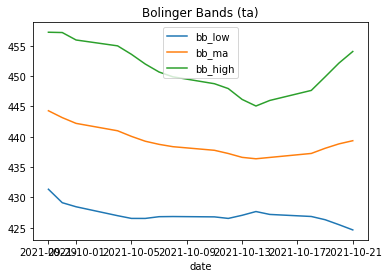

In [5]:
# Visualize BollingerBand

ohlc[["bb_low", "bb_ma", "bb_high"]].plot(title="Bolinger Bands (ta)")

In [6]:
# Save ohlc to Linea DB
artifact = lineapy.save(ohlc,'spy_ohlc')

In [7]:
# Verify the artifact is saved
import datetime
print(datetime.datetime.now())
[x for x in lineapy.catalog().artifacts if x.name=='spy_ohlc'][-1]

2022-04-05 01:00:10.997759


LineaArtifact(execution_id='ad011e7a-4134-47d9-89bc-c955da4c5f61', node_id='7a06642a-057a-4aab-8911-5c086612725b', session_id='572b2566-421d-45c7-9856-ff0899e62144', name='spy_ohlc', date_created=datetime.datetime(2022, 4, 5, 1, 0, 10, 971044))

In [8]:
# The clean version of code to get ohlc
print(artifact.code)

import pandas as pd
import ta
df = pd.read_csv(
    'data/SPY.csv', 
).assign(
    timestamp = lambda df: df.apply(
        lambda r: pd.Timestamp(f'{r.date} {r.time}'), axis=1
    )
)
times = pd.to_datetime(df.date)
ohlc = df.groupby([times.dt.date]).aggregate({
    'open': lambda x: x.head(1),
    'high': max,
    'low': min,
    'close': lambda x: x.tail(1),
    'volume': sum
}).assign(
    daily_return = lambda df: (df.close - df.open)/df.open,
).assign(
    lastday_return = lambda df: df.daily_return.shift(1)
)
ta_bbands = ta.volatility.BollingerBands(close=ohlc['close'], window=20, window_dev=2)
ohlc = ohlc.assign(
    bb_ma = ta_bbands.bollinger_mavg(),
    bb_high = ta_bbands.bollinger_hband(),
    bb_low = ta_bbands.bollinger_lband(),
)



In [9]:
# Source code for entire session
print(artifact.session_code)

import datetime
import lineapy

import pandas as pd
import ta
# Data source: https://www.kaggle.com/datasets/abidou/spy-intraday-ohlc
# You can switch to any data source like Yahoo Finance or other third-party data providers

df = pd.read_csv(
    'data/SPY.csv', 
).assign(
    timestamp = lambda df: df.apply(
        lambda r: pd.Timestamp(f'{r.date} {r.time}'), axis=1
    )
)

df.head()
# Calculate daily OHLC aggregation based on per-minute intraday data

times = pd.to_datetime(df.date)
ohlc = df.groupby([times.dt.date]).aggregate({
    'open': lambda x: x.head(1),
    'high': max,
    'low': min,
    'close': lambda x: x.tail(1),
    'volume': sum
}).assign(
    daily_return = lambda df: (df.close - df.open)/df.open,
).assign(
    lastday_return = lambda df: df.daily_return.shift(1)
)
ohlc.tail()
# Calculate BollingerBand with ta library

ta_bbands = ta.volatility.BollingerBands(close=ohlc['close'], window=20, window_dev=2)
ohlc = ohlc.assign(
    bb_ma = ta_bbands.bollinger_mavg(),

In [10]:
# Outuput Airflow Dag
# Waiting for LIN-294 finish to demonstrate we can save the airflow dag to whatever folder we want

# artifact.to_airflow();